![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr ƒÜwiakowski

### Lekcja 2. Modele typu white-box

#### Spis tre≈õci:

1. Wprowadzenie
2. Drzewa decyzyjne
3. General Additive Model (GAM)¬∂

# 1 Wprowadzenie

Czasami, kiedy jednoznaczne wyja≈õnienie mechanizmu generowania prognoz jest kluczowe, nie mo≈ºemy korzystaƒá ze z≈Ço≈ºonych modeli uczenia maszynowego. Musimy wtedy skorzystaƒá z tzw. modeli transparentnych, jak:

- modele liniowe (OLS, logit, etc.),
- drzewa decyzyjne,
- General Additive models. 

Modele liniowe sƒÖ absolutnie podstawowym narzƒôdziem, wiƒôc om√≥wimy jedynie dwie pozosta≈Çe techniki. Przygotujmy dane i pakiety do dalszej analizy.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline

import pydotplus
from six import StringIO 
from IPython.display import Image  
from svglib.svglib import svg2rlg # pip install svglib
from sklearn.tree import export_graphviz 

# Machine learing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.datasets import load_diabetes

# Modele
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from pygam import LinearGAM, s, te, f, LogisticGAM

In [2]:
df = pd.read_csv("data/bank-balanced.csv")
print(df.shape)

target = "deposit"
numFeatures = ['age', 'balance', 'duration', 'campaign', 'pdays','previous', 'day']
catFeatures = [ 'job', 'marital', 'education', 'default',  'housing', 'loan', 'contact',  'month', 'poutcome']

df[target] = (df[target]=="yes").astype(int)

mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, kt√≥ry bƒôdzie przechowywa≈Ç naszƒÖ mapƒô
    le = LabelEncoder()
    # Dopasowujemy danƒô (tworzymy mapƒô) i od razu jƒÖ nakadamy na zmiennƒÖ na kt√≥rej robili≈õmy dopasowanie
    df[feature] = le.fit_transform(df[feature])

    # Zapiszmy nasza mapƒô, aby m√≥c odzyskaƒá oryginalne dane bez problemu
    mapy[feature] = le
    
features = df.columns.tolist()
features.remove(target)
print(features)

df.head()

(11162, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


age  job  marital  education  default  balance  housing  loan  contact  \
0   59    0        1          1        0     2343        1     0        2   
1   56    0        1          1        0       45        0     0        2   
2   41    9        1          1        0     1270        1     0        2   
3   55    7        1          1        0     2476        1     0        2   
4   54    0        1          2        0      184        0     0        2   

   day  month  duration  campaign  pdays  previous  poutcome  deposit  
0    5      8      1042         1     -1         0         3        1  
1    5      8      1467         1     -1         0         3        1  
2    5      8      1389         1     -1         0         3        1  
3    5      8       579         1     -1         0         3        1  
4    5      8       673         2     -1         0         3        1

Wykonajmy macierz korelacji miƒôdzy zmiennymi:

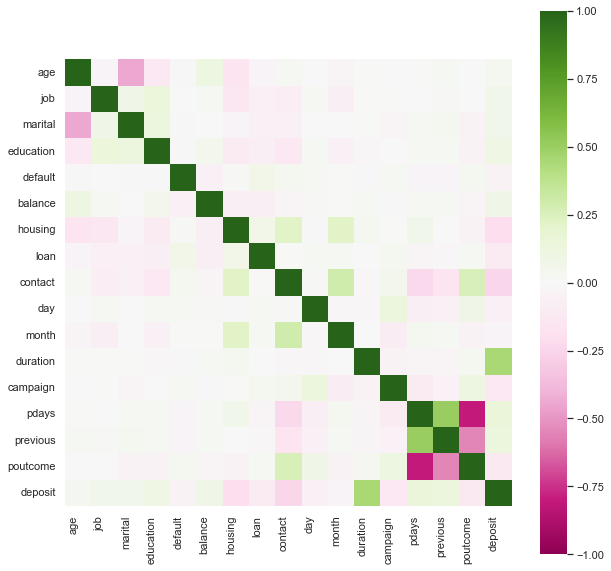

In [3]:
corr = df.corr()

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap="PiYG", square=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(df, df['deposit'], test_size=0.2, random_state=42, stratify=df['deposit'])

# 2 Drzewa decyzyjne

Drzewa decyzyjne sƒÖ podstawƒÖ wielu modeli z≈Ço≈ºonych (lasy losowe, boosting). Model by≈Ç omawiany na kursie podstawowym, wiƒôc poprzestaniemy jedynie na przedstawieniu przyk≈Çadu aplikacyjnego.

In [5]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt_depth3 = DecisionTreeClassifier(max_depth=3, random_state=42)

In [6]:
dt = dt.fit(X_tr[features], y_tr)
dt_depth3 = dt_depth3.fit(X_tr[features], y_tr)

In [7]:
pred_dt_tr = dt.predict_proba(X_tr[features])[:,1]
pred_d3_tr = dt_depth3.predict_proba(X_tr[features])[:,1]
pred_dt_te = dt.predict_proba(X_te[features])[:,1]
pred_d3_te = dt_depth3.predict_proba(X_te[features])[:,1]

In [8]:
roc_auc_score(y_tr, pred_dt_tr), roc_auc_score(y_te, pred_dt_te)

(1.0, 0.7805799782809798)

In [9]:
roc_auc_score(y_tr, pred_d3_tr), roc_auc_score(y_te, pred_d3_te)

(0.8290541170760244, 0.835413264690504)

In [10]:
print(features)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


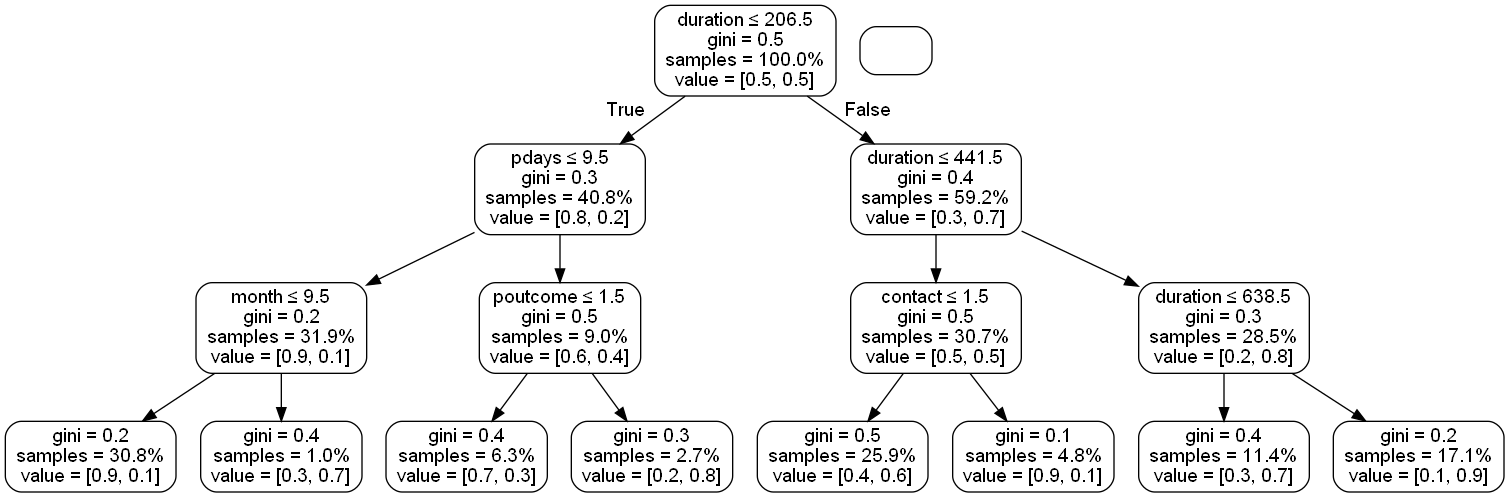

In [11]:
# UWAGA! Je≈õli procedura mimo instalacji pakietu nie bƒôdzie dzia≈Ça≈Ça, trzeba wej≈õci na stronƒô: https://graphviz.org/download/ 
# i zainstalowaƒá odpowiedniƒÖ wersjƒô poprzez plik .exe (np. graphviz-4.0.0 (64-bit) EXE installer [sha256]s)

bank_dt_dot_data = StringIO()
export_graphviz(dt_depth3, out_file=bank_dt_dot_data,
                filled=False, rounded=True,
                feature_names=features,
                proportion=True, precision=1,
                special_characters=True)

dt_graph = pydotplus.graph_from_dot_data(bank_dt_dot_data.getvalue())  

Image(dt_graph.create_png())

In [12]:
bank_dt_dot_data = StringIO()
export_graphviz(dt, out_file=bank_dt_dot_data,
                filled=False, rounded=True,
                feature_names=features,
                proportion=True, precision=1,
                special_characters=True)

dt_graph = pydotplus.graph_from_dot_data(bank_dt_dot_data.getvalue())  

Image(dt_graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.461923 to fit



Text(0, 0.5, 'Features')

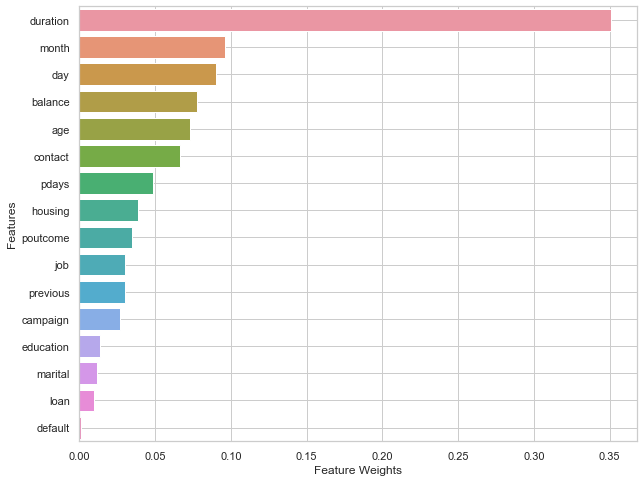

In [13]:
weights = dt.feature_importances_
sort = np.argsort(weights)[::-1]

feature_imp = [features[idx] for idx in sort]
feature_imp_val = [weights[idx] for idx in sort]

f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_imp_val, y=feature_imp, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')

Tuning w `sklearn`:

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

clf = DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_tr[features], y_tr)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_tr, grid_cv.predict(X_tr[features])))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_te, grid_cv.predict(X_te[features])))

Param for GS {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV score for GS 0.8656664058777989
Train AUC ROC Score for GS:  0.8169020011734025
Test AUC ROC Score for GS:  0.8101978844065478


In [ ]:
# Post pruning:
# https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

### underfitting v. overfitting

In [14]:
np.random.seed(42)
n_samples = 100

X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100

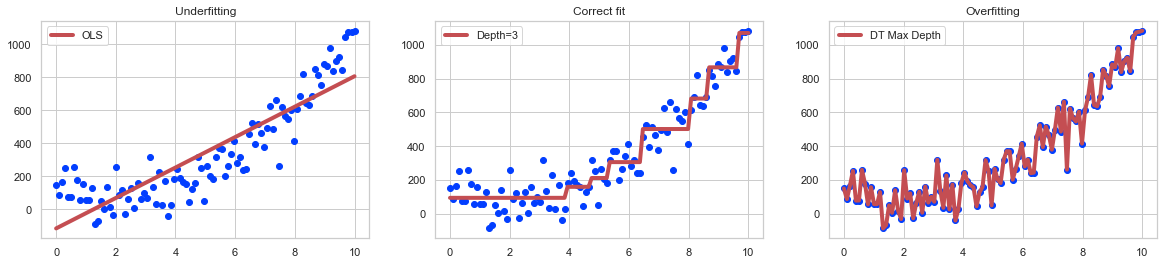

In [15]:
f, ax = plt.subplots(ncols=3, figsize=(20, 4))

lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)
model_pred = lr.predict(X.reshape(-1,1))


# Underfitting
ax[0].scatter(X, y)
ax[0].plot(X, model_pred, 'r-', label='OLS', linewidth=4);
ax[0].set_title('Underfitting')
ax[0].legend()

dt = DecisionTreeRegressor(random_state=42, max_depth=3)
dt.fit(X.reshape(-1, 1), y)
model_pred = dt.predict(X.reshape(-1,1))

ax[1].scatter(X, y)
ax[1].plot(X, model_pred, 'r-', label='Depth=3', linewidth=4);
ax[1].set_title('Correct fit')
ax[1].legend()

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X.reshape(-1, 1), y)
model_pred = dt.predict(X.reshape(-1,1))

ax[2].scatter(X, y)
ax[2].plot(X, model_pred, 'r-', label='DT Max Depth', linewidth=4);
ax[2].set_title('Overfitting')
ax[2].legend()

# 3 General Additive Model (GAM)

## 3.1 Wprowadzenie

Modele klasy GAM umo≈ºliwiajƒÖ szacowanie nieliniowych zale≈ºno≈õci w modelach addytywnych. Dziƒôki temu:
* sƒÖ relatywnie ≈Çatwe w interpretacji,
* bardzo elastyczna forma funkcyjna umo≈ºliwia znajdowanie w danych nieoczywistych i nieliniowych zale≈ºno≈õci,

Ponadto:
* model ma wbudowanƒÖ regularyzacjƒô, przez co unikamy przetrenowania modelu,
* w GAM mo≈ºna wykorzystywaƒá nieliniowe link function ‚Äì jak w GLM - dlatego za pomocƒÖ GAM mo≈ºna rozwiƒÖzywaƒá za r√≥wno problemy regresyjne jak klasyfikacyjne.

Mimo oczywistych zalet, modele GAM nie sƒÖ jednak popularnymi technikami w biznesie ‚Äì wyb√≥r postaci funkcyjnej, mimo pewnej automatyzacji wymaga rƒôcznej specyfikacji, pracy teoretycznej (potencjalne interakcje miƒôdzy zmiennymi) oraz pomys≈Çu. Je≈õli mamy do czynienia z 100+ lub nawet 20+ zmiennymi, proces wymaga od nas zbyt wiele czasu, stƒÖd czƒô≈õciej stosowane SVM, Random Forest czy boostowane drzewa. GAM mo≈ºe okazaƒá siƒô dobrym pomys≈Çem dla zbior√≥w danych ma≈Çych pod wzglƒôdem liczby obserwacji (poni≈ºej 2-5K obserwacji) oraz kolumn (przyk≈Çadowo mniej niz 10). Ponadto zmienne powinny byƒá ciƒÖg≈Çe, ≈ºeby mo≈ºna by≈Ço skorzystaƒá z atut√≥w modelu.  

W podej≈õciu stosowanym przez GAM szacuje siƒô nastƒôpujƒÖcy model:

$$ùëî(ùê∏(ùë¶))=Œ≤+ùëì_1 (ùë•_1)+ùëì_2 (ùë•_2)+‚Ä¶+ùëì_ùëò (ùë•_ùëò)$$

gdzie:
g(.) ‚Äì funkcja link, pozwalajƒÖ przekszta≈Çciƒá zale≈ºno≈õƒá miƒôdzy Y a X na liniowƒÖ (additive predictor),   
ùëì_ùëñ (.) - g≈Çadkie, nieparametryczne transformacje zmiennej ùë•_ùëñ,

Przyk≈Çadowy wynik mo≈ºe byƒá nastƒôpujƒÖcy:

<img src="img/gam1.png" width="50%">
≈πr√≥d≈Ço: http://multithreaded.stitchfix.com/blog/2015/07/30/gam/

## 3.2 Zrozumieƒá GAM

Po zapoznaniu siƒô z ideƒÖ modelu, mo≈ºna przej≈õƒá do odpowiedzi na pytamie jak w istocie znajdowane sƒÖ te g≈Çadkie, nieliniowe transformacje zmiennych. Punktem wyj≈õcia sƒÖ oczywi≈õcie wielomiany. Okazuje siƒô, ≈ºe ca≈Çkiem nie≈∫le mogƒÖ przybli≈ºaƒá wiele nieliniowych trend√≥w, sp√≥jrzmy na rysunek:

<img src="img/gam2.png" width="40%">
≈πr√≥d≈Ço: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022. 

Wielomiany majƒÖ jednak swoje wady - stopie≈Ñ kazdego wielomianu trzeba ustalaƒá samodzielnie (co przy du≈ºej liczbie zmiennych i mocno nieregularnych efektach mo≈ºe byƒá uciƒÖ≈ºliwe), a poza tym ma tendencje (zgodnie z literaturƒÖ) to przetrenowywania siƒô. Dlatego w GAM korzysta siƒô z bardziej z≈Ço≈ºonych funkcji wyg≈ÇadzajƒÖcych (z ang. *smoothing functions*). NajpopularniejszƒÖ odmianƒÖ sƒÖ tzw. *regression splines* i w≈Ça≈õnie one sƒÖ zaimplementowane w GAM. Wed≈Çug tego podej≈õcia $f_j$ mo≈ºna zapisaƒá jako:

<img src="img/gam3.png" width="20%">
≈πr√≥d≈Ço: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022. 

ZmiennƒÖ $x_j$ dzieli siƒô na K przedzia≈Ç√≥w, z kt√≥rych ka≈ºdy jest modelowany przez osobnƒÖ funkcje bazowƒÖ $b_k$, kt√≥ra jest tzw. spline'em, czyli wielomianem n-tego stopnia. Do odzwierciedlenia wiƒôkszo≈õci kszta≈Çt√≥w zazwyczaj wystarczy wielomian 3-ciego stopnia. Dlatego spline'y tego typu nazywamy *cubic splines*. Algorytm musi nauczyƒá siƒô wagi dla ka≈ºdej funkcji bazowej (w ten spos√≥b manipuluje kszta≈Çtem - w celu zmiany linii trendu wygasza niekt√≥re wielomiany). Liczba przedzia≈Ç√≥w (zwana r√≥wnie≈º liczbƒÖ stopni swobody) - K - ustalana jest "automatycznie" przez model i nie musimy siƒô niƒÖ przejmowaƒá. Poni≈ºej zilustrowano dwa rozwiƒÖzania - dla r√≥wnych i nier√≥wnych wag:

<img src="img/gam4.png" width="60%">
≈πr√≥d≈Ço: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022. 

Poniewa≈º GAM bardzo ≈Çatwo siƒô przetrenowuje, potrzebny jest komponent regularyzacyjny $\lambda$ u≈ºywany analogicznie jak w L1/L2: 

<img src="img/gam5.png" width="20%">

Na rysunku poni≈ºej zilustrowano wp≈Çyw parametru $\lambda$ na gibko≈õƒá dopasowanego modelu:

<img src="img/gam6.png" width="50%">
≈πr√≥d≈Ço: https://multithreaded.stitchfix.com/blog/2015/07/30/gam/

## 3.3 Przyk≈Çad aplikacyjny ( z ksiƒÖ≈ºki *Interpretable AI:  Building explainable machine learning systems*)

In [3]:
# Wczytanie i przygotowanie danych
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target'] 
# Target: Column 11 is a quantitative measure of disease progression one year after baseline
# Dokumentacja zbioru:
print(diabetes['DESCR'])

# Podzia≈Ç na zbi√≥r treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista zmiennych objasniajƒÖcych
feature_names = ['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Definiowanie modelu
gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), n_splines=35) # n_splines - max. K dla funkcji wyg≈ÇadzajƒÖcej

# Z ksiƒÖzki Inrepretable AI:
# Uses grid search to perform training and crossvalidation
# to determine the number of splines, the
# regularization parameter lambda, and the optimum
# weights for the regression splines for each feature

gam.gridsearch(X_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + intercept,
   tol=0.0001, verbose=False)

In [26]:
# Podsumowanie
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.7114
Link Function:                     IdentityLink Log Likelihood:                                  -3142.722
Number of Samples:                          353 AIC:                                             6342.8668
                                                AICc:                                            6348.1441
                                                GCV:                                             3411.4587
                                                Scale:                                            2933.054
                                                Pseudo R-Squared:                                   0.5552
Feature Function                  Lam

C:\Users\pcwia\AppData\Local\Temp\ipykernel_3508\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [5]:
# B≈Çƒôdy dopasowania (mo≈ºna z ciekawo≈õci por√≥wnaƒá z tradycyjnym modelem)
y_pred = gam.predict(X_test)

mae = np.mean(np.abs(y_test - y_pred))
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs(y_test - y_pred) / y_test) * 100
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 41.383326521833155
RMSE: 52.229910552735696
MAPE: 35.674305762856804


Por√≥wnanie GAM z innymi modelami:

<img src="img/gam7.png" width="40%">
≈πr√≥d≈Ço: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022.

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


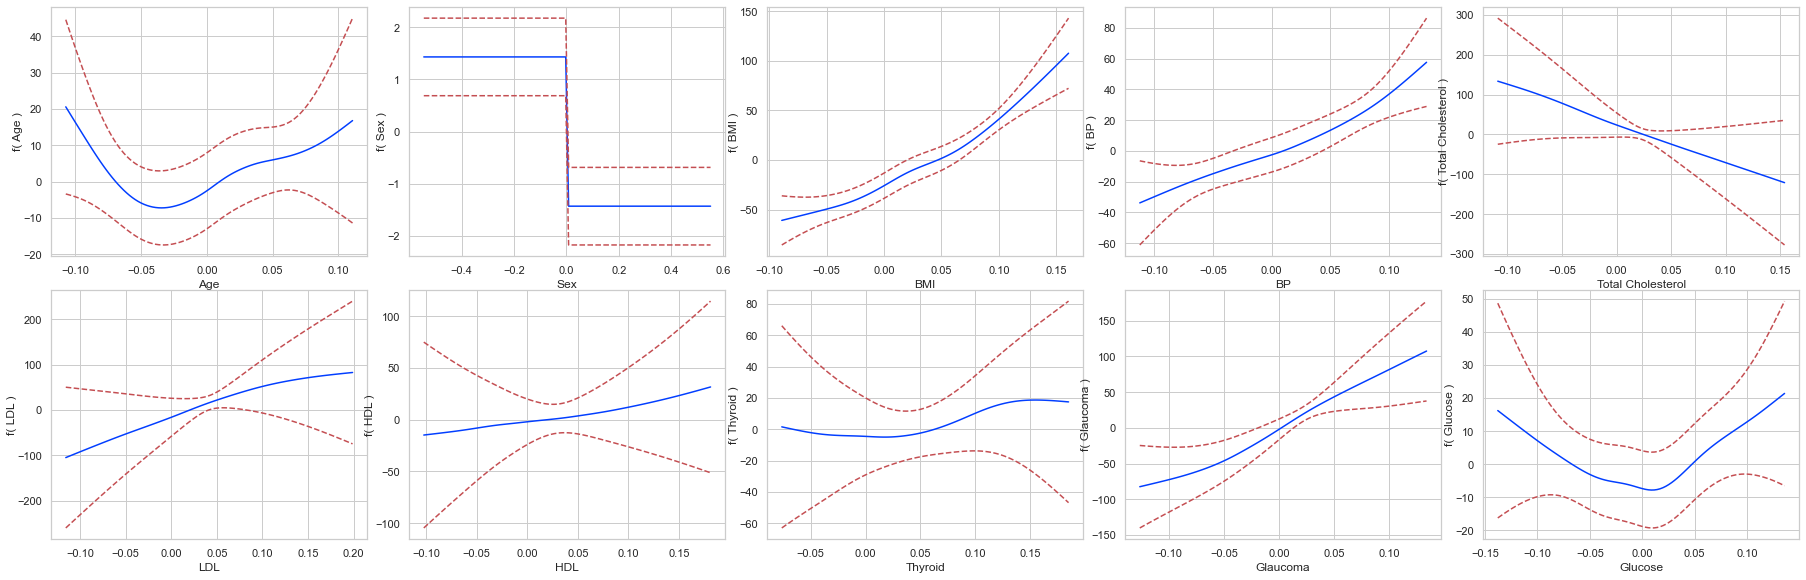

In [6]:
# Wygenerowanie funkcji reakcji:
print(feature_names)

# Mapowanie pozycji ka≈ºdegi wykresu (wiersz, kolumna)
grid_locs1 = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
              (1, 0), (1, 1), (1, 2), (1, 3), (1, 4)]

# Tworzenie p≈Ç√≥tna i osi
fig, ax = plt.subplots(2, 5, figsize=(25, 8))

fig.tight_layout(pad=1)
# Wype≈Çnienie osi
for i, feature in enumerate(feature_names):
    gl = grid_locs1[i]
    ax1 =  ax[gl[0], gl[1]]
    XX = gam.generate_X_grid(term=i)
    ax1.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax1.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax1.set_xlabel(f'{feature}')
    ax1.set_ylabel(f'f( {feature} )', labelpad=0)